## NN Oefeningen GLMs 

*"Not everything that counts can be counted, and not everything that can be counted counts" - Albert Einstein* 

In deze oefeningen werken we verder met het opgeschoonde bestand uit de vorige opdracht. We bouwen eerst een GLM om het aantal claims te voorspellen, waarbij we gebruikmaken van een Poisson-distributie.

Daarnaast maken we een tweede GLM om het gemiddelde schadebedrag per claim (ook wel severity genoemd) te voorspellen op basis van een Gamma-distributie. Door deze twee voorspellingen met elkaar te vermenigvuldigen kunnen we vervolgens het totale verwachte schadebedrag berekenen.

Je kunt dit volledige proces ook in één keer modelleren met een Tweedie-distributie. In deze oefening doen we dat echter niet, zodat we de prestaties van beide onderdelen afzonderlijk kunnen analyseren.



In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import helper_funcs as helpers


# Opdracht 1. Laatste voorbereiding op de GLM

## Opdracht 1.1 Lees de train_set en de test_set in


## Opdracht 1.2 Definieer X_train, y_train, X_test en y_test
Definieer de features (X_train/X_test) die we gaan gebruiken om ons model te trainen. Verwijder hiervoor uit het bijbehorende dataframe de kolommen die niet als input voor het model mogen dienen. Dit zijn de kolommen die niet in X_train mogen zitten:

* ClaimAmount
    - Dit is de waarde die we willen voorspellen (**onze target**).  
    - Als we deze kolom als feature gebruiken, krijgt het model direct de uitkomst te zien, wat **data leakage** veroorzaakt en de evaluatie volledig onbetrouwbaar maakt.
* ClaimNb
    - Dit is het aantal claims per polis.  
    - Dit is nauw gerelateerd aan het target (`ClaimAmount`) en mag daarom **niet gebruikt worden als input**, anders leert het model “stiekem” van de uitkomst.
* PurePremium
    - Dit is de totale claim per eenheid exposure (`ClaimAmount / Exposure`).  
    - Dit is een afgeleide van het target (`ClaimAmount`), dus ook **niet toegestaan als feature**.
* Frequency
    - Dit is het aantal claims per exposure-eenheid (`ClaimNb / Exposure`).  
    - Dit is een component van de Pure Premium en dus sterk gerelateerd aan het target. Het gebruik hiervan leidt tot **oneerlijke voorspellingen**.
* AvgClaimAmount
    - Gemiddelde schadebedrag per claim (`ClaimAmount / ClaimNb`).  
    - Dit is een ander afgeleid target, en bevat directe informatie over `ClaimAmount`. Moet daarom **buiten het model blijven**.
* Exposure
    - De blootstelling van de polis.  
    - Dit kan een feature zijn, maar in veel modellen (en bij ons ook) wordt het **geïntegreerd in het model via offset** (bijvoorbeeld bij de Poisson-regressie). In dit geval sluit je het tijdelijk uit om consistentie te behouden.
* DrivAge & VehAge
    - Deze kolommen zijn al **geprocessed** in de vorm van binned of geschaalde features.  
    - Het opnemen van de originele numerieke waarden kan leiden tot **dubbele informatie** en verkeerde interpretatie door het model.

De target y_train en y_test kies je bij het maken van je GLM en bevat alleen de te voorspellen kolom.




## Opdracht 1.3: Laatste check

Om zeker te weten dat we een consistente check hebben - test:
1. Of je kolommen van X_train en X_test exact hetzelfde zijn
2. Of er geen missende waardes in X_train of X_text zitten 
3. Of alle waarden in X_train/X_test int, bool of float zijn

# 2. Frequency Voorspellen: Poisson

Met de functie `PoissonRegressor` uit scikit-learn kunnen we een GLM opstellen om de frequentie van claims te voorspellen.  
Gebruik hierbij de argumenten `alpha=1e-4` en `solver='newton-cholesky'`.  

Nadat je de GLM hebt gedefinieerd, train je het model met:

```python

y_train = df_train["Frequency"]
jouw_glm.fit(X_train, y_train, sample_weight=df_train["Exposure"])
``` 
Hierbij gebruik je X_train als input, Frequency als target en Exposure als sample weights.

In het bestand helper_funcs.py staat een functie genaamd score_estimator, die automatisch de prestaties van je GLM berekent. Je hoeft deze functie dus niet zelf te programmeren.
Roep de functie als volgt aan:
```python
scores = helpers.score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)

print(scores)
```
## Opdracht 2.1 Definieer de GLM en print de scores


## Opdracht 2.2:
In het bestand `helper_funcs.py` staat ook een functie `plot_obs_pred`, die een grafiek maakt van de **gemodelleerde resultaten versus de geobserveerde waarden**.  

Je roept de functie als volgt aan:

```python
helpers.plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)
```


Maak een figuur met 4 subplots (2 rijen, 2 kolommen).

Plot de volgende combinaties:
 
 | Subplot  | Feature                          | Dataset |
| -------- | -------------------------------- | ------- |
| ax[0, 0] | `DrivAge`                        | X_train |
| ax[0, 1] | `DrivAge`                        | X_test  |
| ax[1, 0] | `VehAge`                         | X_test  |
| ax[1, 1] | `BonusMalus` (schadevrije jaren) | X_test  |


## Opdracht 2.3: Resulaten omschrijven

Beschrijf welke van de features `DrivAge`, `VehAge` en `BonusMalus` je model beïnvloeden. Kan het model het geobserveerde patroon herkennen en reproduceren?

# Opdracht 3: Claimamount voorspellen: Gamma



### Opdracht 3.1: Average Claim Amount voorspellen met een Gamma GLM

In deze stap gaan we de **severity** van claims voorspellen, oftewel het **gemiddelde claimbedrag per claim** (`AvgClaimAmount`).  
Omdat het gemiddelde claimbedrag altijd positief is en continu varieert, gebruiken we hiervoor een **Gamma regressie** via `GammaRegressor` uit scikit-learn.

**Stappen:**

1. Selecteer alleen de polisregels waarvoor daadwerkelijk een claim is ingediend (`ClaimAmount > 0`).  
   - Dit voorkomt dat het model vertekend wordt door records zonder claims.

2. Definieer een Gamma GLM met bijvoorbeeld:
   ```python
   glm_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")

Train het model op de trainingsset:
- **Features:** `X_train` (alleen voor records met `ClaimAmount > 0`)  
- **Target:** `AvgClaimAmount`  
- **Sample weights:** gebruik `ClaimNb` zodat polissen met meerdere claims meer invloed hebben.

Evalueer het model op zowel de train- als testset met de helperfunctie `score_estimator`:

- Pas dezelfde filter (`ClaimAmount > 0`) toe op de testset.  
- Gebruik `AvgClaimAmount` als target en `ClaimNb` als weights.  
- Print de resultaten om de prestaties van het Gamma GLM te bekijken.

---

*Doel*
Door dit te doen kun je inschatten hoe goed het model het gemiddelde schadebedrag per claim voorspelt, onafhankelijk van de claimfrequentie.  
Dit is een belangrijke stap in de klassieke **twee-staps benadering** van Pure Premium:
```python
Pure Premium = Frequency * Severity


In [2]:
from sklearn.linear_model import GammaRegressor


### 3.2 Visualiseer de Gamma GLM

Gebruik de plot_obs_pred functie opnieuw om een plotje te maken. 
De observed is nu `AvgClaimAmount`.

Maak een figuur met 2 subplots (2 rijen, 1 kolom).

Plot de volgende combinaties:
 
 | Subplot  | Feature                          | Dataset |
| -------- | -------------------------------- | ------- |
| ax[0] | `DrivAge`                        | X_train |
| ax[1] | `DrivAge`                        | X_test  |

Je ziet dat de Driver Age niet veel invloed heeft de voorspelde Claim Severity

### 3.3 Hoe doet ons schadelast (severity) model het?

# 4. De Pure Premium

## Opdracht 4.1 Scores van de Pure Premium

Om de Pure Premium (Freq x Severity) te voorspellen, gebruiken we het product van onze eerdere voorspellers. Dit gebeurt op deze manier:

`y_pred = glm_freq.predict(X) * glm_sev.predict(X)`

Dit wordt automatisch meegenomen in de helpers.score_estimator functie wanner je als eerste input argument (estimator) de tuple van glm_freq en glm_sev mee geeft in plaats van een enkele estimator. Dus:

```python
scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

Bereken en print de scores van de Pure Premium model

## Opdracht 4.2: Lorenz-curve

Als laatste onderdeel bekijken we de prestaties van het **frequency × severity model** met een Lorenz-curve.  

Een Lorenz-curve is een grafiek die laat zien hoe een bepaalde waarde verdeeld is over een populatie. In verzekeringen wordt deze vaak gebruikt om te beoordelen hoe goed een model onderscheid kan maken tussen **lage- en hoge-risicopolissen**.

---

**Werkwijze bij maken van Lorenz curve**

1. Sorteer alle polissen op basis van hun **voorspeld risico** (bijvoorbeeld de voorspelde Pure Premium), van laag naar hoog.  
2. Bereken de **cumulatieve percentages van de exposure** (het aandeel van het totaal aan polissen of premie dat tot dat punt is meegerekend).  
3. Bereken de **cumulatieve percentages van de claimkosten** (het aandeel van het totaal aan claims dat bij deze polissen hoort).  
4. Zet deze twee cumulatieve percentages tegen elkaar uit in een grafiek.

---

**Interpretatie van de Lorenz Curve**

- Als de curve **dicht bij de diagonaal** ligt → het model maakt nauwelijks onderscheid tussen lage- en hoge-risicopolissen.  
- Hoe **meer de curve afbuigt van de diagonaal**, hoe beter het model de **risicovolle polissen** kan identificeren.  
- De Lorenz-curve wordt vaak gebruikt om de **Gini-index** te berekenen, een maat voor de kwaliteit van het model.  

**Kort gezegd:** de Lorenz-curve laat visueel zien hoe goed je model de **hoogste risico’s bovenaan** kan zetten.

---

*Opdracht*

In het bestand `helpers.py` staat een functie:

`plot_lorenz_curve(glm_freq, glm_sev, X_test, df_test, ax)`

Gebruik deze functie om de Lorenz-curve van het frequency × severity model te maken. Beschrijf vervolgens kort het resultaat: hoe goed kan het model lage en hoge risico’s onderscheiden volgens de grafiek?


# Antwoorden

#### Antwoord Opdracht 1.1



In [27]:
df_train = pd.read_csv(r'./Data/train_set.csv')
df_test = pd.read_csv(r'./Data/test_set.csv')

#### Antwoord Opdracht 1.2

In [28]:
X_train = df_train.drop(columns=['ClaimAmount', 'ClaimNb', 'PurePremium', 'Frequency', 'AvgClaimAmount', 'Exposure', 'DrivAge', 'VehAge' ])
y_train = df_train['ClaimAmount']

X_test = df_test.drop(columns=['ClaimAmount', 'ClaimNb' ,'PurePremium', 'Frequency', 'AvgClaimAmount',  'Exposure', 'DrivAge', 'VehAge' ])
y_test = df_test['ClaimAmount']

display(X_train)

,BonusMalus,VehGas_Diesel,VehGas_Regular,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,VehBrand_B14,VehBrand_B2,...,"DrivAge_bin_(17.999, 28.0]","DrivAge_bin_(28.0, 32.0]","DrivAge_bin_(32.0, 36.0]","DrivAge_bin_(36.0, 40.0]","DrivAge_bin_(40.0, 44.0]","DrivAge_bin_(44.0, 48.0]","DrivAge_bin_(48.0, 53.0]","DrivAge_bin_(53.0, 57.0]","DrivAge_bin_(57.0, 65.0]","DrivAge_bin_(65.0, 100.0]"
0,50,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,50,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,62,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,50,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,55,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474604,76,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
474605,95,False,True,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
474606,50,False,True,False,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
474607,80,False,True,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False


#### Antwoord Opdracht 1.3

In [29]:
# 1 check columns
if list(X_train.columns) == list(X_test.columns):
    print("✅ De kolommen van X_train en X_test zijn exact hetzelfde.")

# 2️ Check op missende waardes
if (X_train.isna().sum() > 0).any() or (X_test.isna().sum() > 0).any():
    print('missing values in X_train: ', X_train.isna().sum() )
    print('missing values in X_test: ',  X_test.isna().sum() )
else:
    print('✅ geen missende waardes gevonden')

# 3️ Check of alle waarden numeriek (int, float) of boolean zijn
def check_dtypes(df, name):
    check = True
    for col in df.columns:
        dtype = df[col].dtype
        if not (np.issubdtype(dtype, np.integer) or 
                np.issubdtype(dtype, np.floating) or
                np.issubdtype(dtype, np.bool_)):
            print(f"Kolom '{col}' in {name} is van type {dtype}, geen int, float of bool.")
            check = False
    return check

dtypes_train = check_dtypes(X_train, "X_train")
dtypes_test = check_dtypes(X_test, "X_test")
if dtypes_train & dtypes_test:
    print('✅ alle dtypes zijn numeriek of bool')

✅ De kolommen van X_train en X_test zijn exact hetzelfde.
✅ geen missende waardes gevonden
✅ alle dtypes zijn numeriek of bool


#### Antwoord 2.1

In [30]:
glm_freq = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
y_train =  df_train["Frequency"]
glm_freq.fit(X_train, y_train, sample_weight=df_train["Exposure"])

scores = helpers.score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0363  0.0366
mean abs. error     0.1783  0.1802
mean squared error  0.2418  0.2378


#### Antwoord 2.2

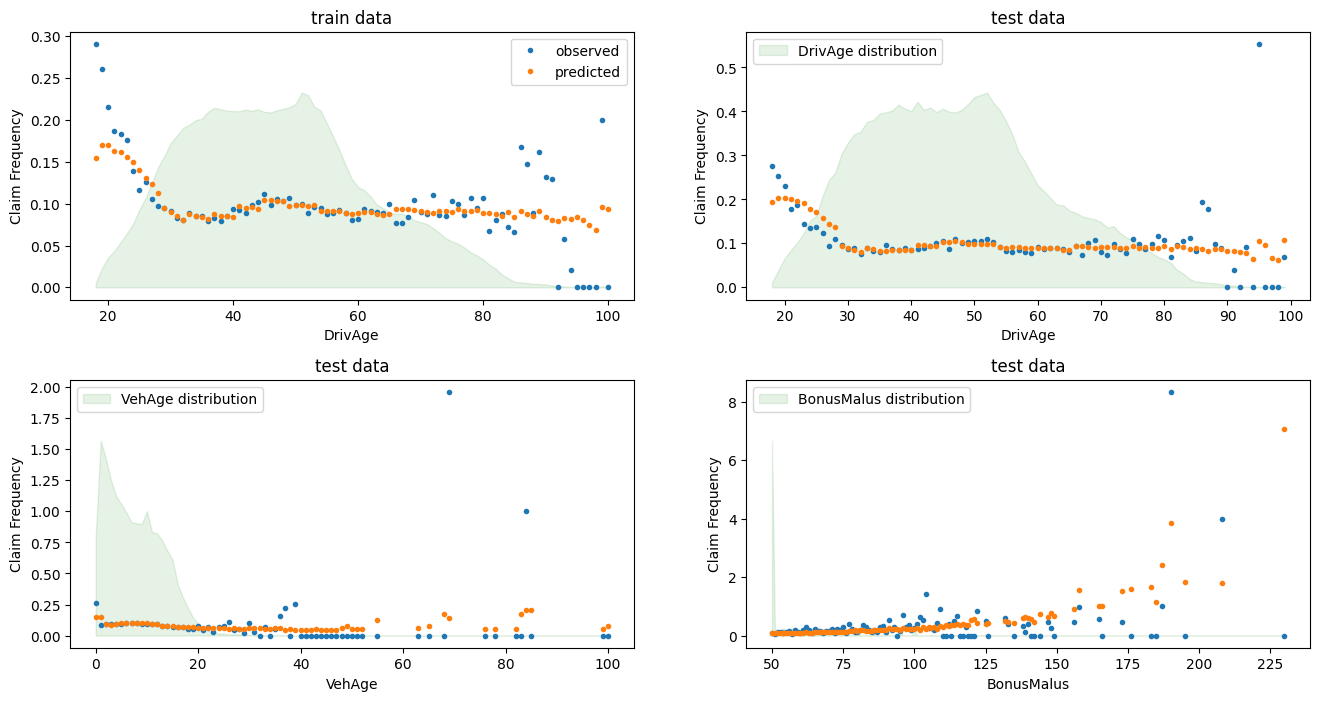

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

helpers.plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)



helpers.plot_obs_pred(
    df=df_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True,
)

helpers.plot_obs_pred(
    df=df_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 0],
    fill_legend=True,
)

helpers.plot_obs_pred(
    df=df_test,
    feature="BonusMalus",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 1],
    fill_legend=True,
)

#### Antwoord 2.3
Volgens de geobserveerde data is de schadelast hoger voor bestuurders jonger dan 30 jaar, en is er een positieve relatie tussen schadefrequentie en de BonusMalus-score. Er is weinig invloed van de VehAge op de schadefrequentie.
Ons model weet dit patroon grotendeels correct te herkennen en te reproduceren in de voorspellingen.


#### Antwoord 3.1

In [9]:

mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")

glm_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = helpers.score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        5.170000e-02 -5.960000e-02
mean abs. error     2.509350e+03  2.057580e+03
mean squared error  1.145632e+09  5.226596e+07


#### Antwoord 3.2

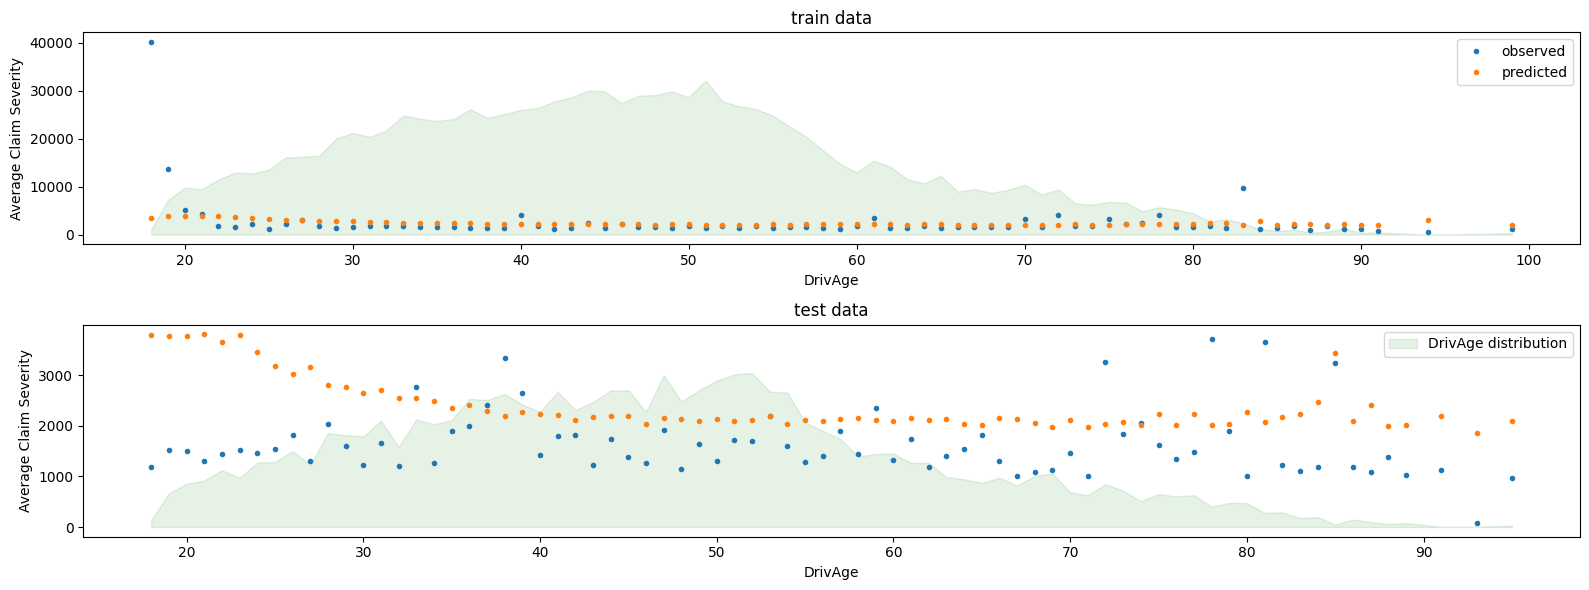

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

helpers.plot_obs_pred(
    df=df_train.loc[mask_train],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

helpers.plot_obs_pred(
    df=df_test.loc[mask_test],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True,
)
plt.tight_layout()

#### Antwoord 3.3

We kunnen concluderen dat het heel moeilijk is om het schadebedrag goed te voorspellen met dit model. Toch lukt het de GammaRegressor om de gegevens een beetje te gebruiken en net iets beter te presteren dan simpelweg het gemiddelde gokken.

**Belangrijk om te beseffen:**

Dit model voorspelt het gemiddelde schadebedrag per claim.
Dat betekent dat het alleen geldt voor mensen die al minstens één claim hebben ingediend.
Je kunt dit model dus niet gebruiken om het gemiddelde schadebedrag per klant te voorspellen.
Daarvoor moet je dit model combineren het frequentiemodel - dat gaan we doen in Opgave 4.

#### Antwoord 4.1


In [11]:
scores_product_model = helpers.score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
)
print(scores_product_model)

subset                     train          test
metric                                        
mean abs. error     3.748132e+02  3.472720e+02
mean squared error  3.835384e+08  3.178034e+07


#### Antwoord 4.2

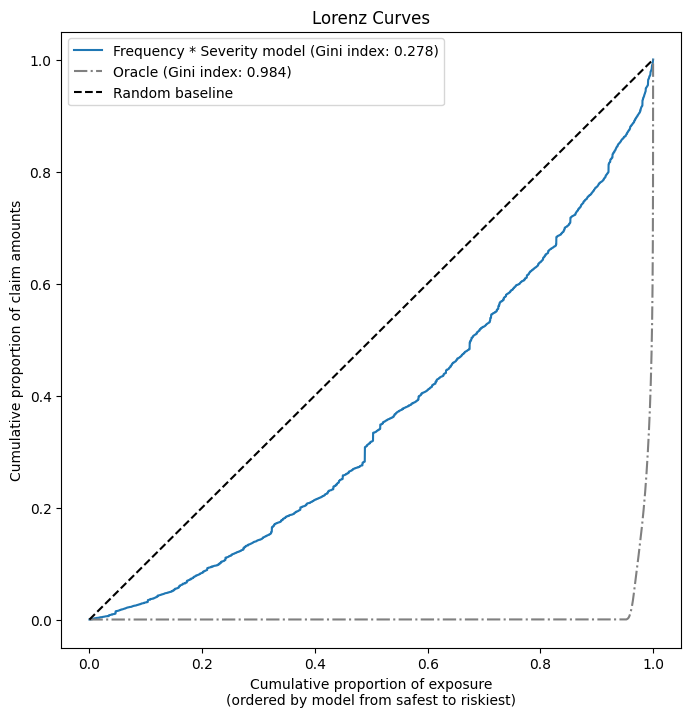

In [12]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(8, 8))

helpers.plot_lorenz_curve(glm_freq, glm_sev, X_test, df_test, ax)

Interpetatie van de Lorenz curve:

We zien dat het frequency × severity model de polissen behoorlijk goed kan rangschikken op risico, veel beter dan willekeurig raden.
Toch blijft het model ver verwijderd van het theoretische beste model (oracle), omdat het voorspellen van schade natuurlijk erg lastig is met slechts een paar kenmerken: de meeste ongelukken zijn niet voorspelbaar en kunnen veroorzaakt worden door omstandigheden die niet in de inputfeatures van het model zitten.

*Belangrijk*: de Gini-index meet alleen hoe goed het model kan rangschikken.
Het zegt niets over de exacte waarde van de voorspellingen (de calibratie).